# Natural language processing breakdown

Companies are clustered into groups with OPTICS based on their company descriptions on Yahoo Finance. The descriptions are cleaned from punctuations, stopword and then lemmatized. I use a maximum of trigrams for the expressions, then TF-IDF transformation, and then - since the resulting matrix is sparse - Singular Value Decompositon. Clusters are created based on the companies cosine distance.

In [1]:
from datetime import datetime, date
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import calendar

import math

from statsmodels.tsa.vector_ar.vecm import coint_johansen
from arch.unitroot import ADF as archADF
from matplotlib import gridspec
import seaborn as sns

import time
import itertools
from hurst import compute_Hc, random_walk
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('wordnet')

from sklearn.metrics.pairwise import cosine_distances, cosine_similarity, euclidean_distances
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings('ignore')

from pylr2 import regress2
from sklearn.cluster import OPTICS
from IPython.display import clear_output

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

from wordcloud import WordCloud
from itertools import compress
from collections import Counter

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
###Parameters
stock_index = 'NIKKEI'          #SNP, NIKKEI, BOVESPA
formation_year = 2017        #2010-2020 - when we take the components of the index
formation_period = 12        #in months, integers only
trading_period = 6          #in months, integers only

#Getting data
comp_stats=pd.read_csv("{}_comp_stats.csv".format(stock_index),index_col=0)
price_data=pd.read_csv("{}_prices2005-2021.csv".format(stock_index),index_col=0)
tickers=pd.read_csv("{}_tickers_2010-2020.csv".format(stock_index),index_col=0)

In [3]:
#Defining formation and trading periods
def create_dates(formation_date):
    trading_start=str(pd.Timestamp(formation_date).date())
    formation_start =str((pd.Timestamp(formation_date)-pd.DateOffset(months=formation_period)).date())
    endD=str((pd.Timestamp(formation_date)+pd.DateOffset(months=trading_period)).date())

    formation_end = str((pd.Timestamp(trading_start)-pd.DateOffset(days=1)).date())
    trading_end = str((pd.Timestamp(endD)-pd.DateOffset(days=1)).date())
    return formation_start, formation_end, trading_start, trading_end

formation_date = '{}-01-01'.format(formation_year)
formation_year = int(formation_date[0:4])
fP1, fP2, tP1, tP2 = create_dates(formation_date)

In [4]:
def clean_data(fP1, tP2, formation_year, stock_index):
    #Only include tickers that are in the stock index for the year and we have data for it
    valid_tickers=(set(price_data[fP1:tP2].columns)) & (set(tickers.loc[formation_year][stock_index]))

    #Drop ticker that miss >20% of their price series, forward fill the rest,
    #then drop the tickers that still has missing values,
    #those can only have it at the start of their price series, would cause problems later in testing
    clean_prices=price_data[fP1:tP2][valid_tickers]
    clean_prices=clean_prices.dropna(axis=1,thresh=round(clean_prices.shape[0]*0.8))
    clean_prices=clean_prices.fillna(method="ffill")
    if pd.isnull(clean_prices.iloc[0]).all():
        clean_prices=clean_prices.drop(clean_prices.index[0], axis=0)
    clean_prices=clean_prices.dropna(axis=1)
    
    return clean_prices

clean_prices = clean_data(fP1, tP2, formation_year, stock_index)

In [5]:
def clean_text(final_summaries):
    cleaned_final_summaries=list()
    for summary in final_summaries:
        summary=summary.lower()
        summary = re.sub(r"[,.\"!@#$%^&*(){}?/;`~:<>+=-]", "", summary)
        tokens = word_tokenize(summary)
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        vect = CountVectorizer(stop_words='english')
        stop_words = list(vect.get_stop_words())
        stop_words.extend(['founded', 'firm', 'company', 'llc', 'inc', 'incorporated'])
        stop_words.remove('not')
        #PS = PorterStemmer()
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(w) for w in stripped if not w in stop_words]
        words = ' '.join(words)
        cleaned_final_summaries.append(words)
        
    return cleaned_final_summaries, stop_words

cleaned_final_summaries, stop_words = clean_text(comp_stats.loc[clean_prices.columns].Summary)

In [6]:
vect = CountVectorizer(
    analyzer='word',
    ngram_range=(1,3),
    strip_accents='unicode',
    max_features=500,
    stop_words=stop_words)

X = vect.fit_transform(cleaned_final_summaries)
tfidf = TfidfTransformer()
X_idf = tfidf.fit_transform(X)

lsa = TruncatedSVD(n_components = 50, n_iter = 5, random_state=1)
X_idf_lsa = lsa.fit_transform(X_idf)
print(round(lsa.explained_variance_ratio_.cumsum()[-1], 4))
print(X_idf_lsa.shape)

0.6252
(214, 50)


In [7]:
min_Samp = 3
clustering = OPTICS(min_samples = min_Samp, xi = 0.01,metric = 'cosine').fit(X_idf_lsa)
clustered_tickers = pd.Series(index = clean_prices.columns,data = clustering.labels_.flatten())

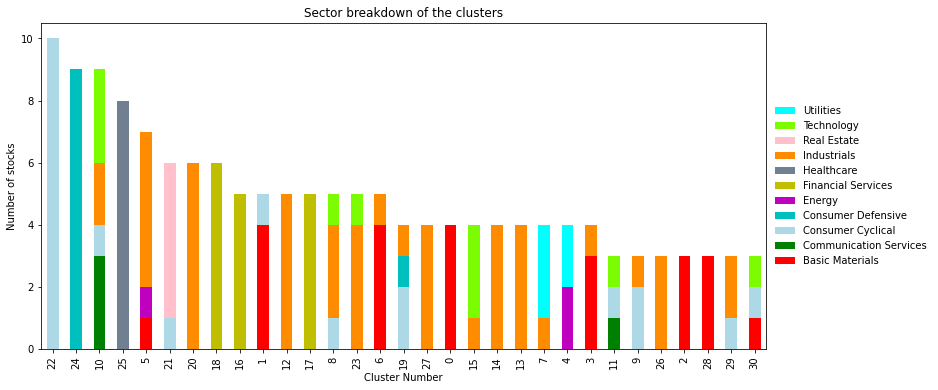

In [8]:
sectors = sorted(list(comp_stats.Sector.unique()))
colors = ['r','g','lightblue','c','m','y','slategrey','darkorange','pink','lawngreen','aqua']
sect_brkdwn = pd.DataFrame(0,index=range(clustered_tickers.max()),columns=sectors)
for i in range(clustered_tickers.max()+1):
    temp = Counter(comp_stats.loc[clustered_tickers[clustered_tickers==i].index].Sector)
    for j in temp:
        sect_brkdwn.loc[i,j] = temp[j]
        
sect_brkdwn.loc[sect_brkdwn.sum(axis=1).sort_values(ascending=False).index].plot(kind='bar', color=colors, stacked=True,figsize=(13,6),title='Sector breakdown of the clusters');
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), labelspacing=-2.5, frameon=False);
plt.xlabel('Cluster Number');
plt.ylabel('Number of stocks');

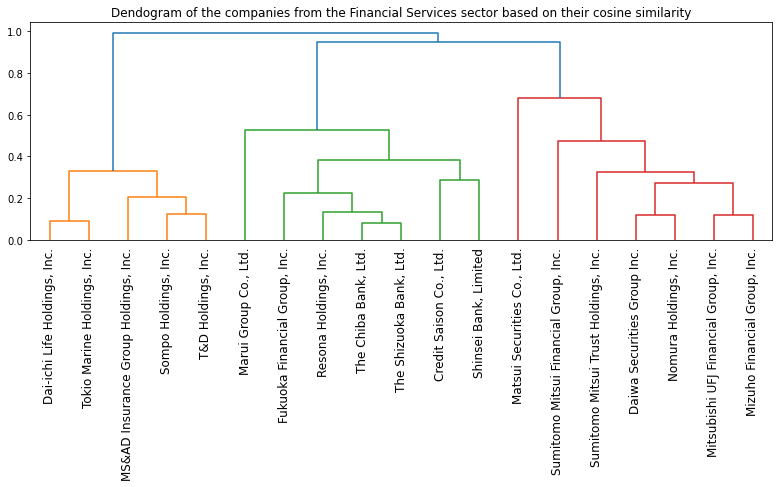

In [9]:
sector = 'Financial Services'

summarySim = 1-cosine_distances(X_idf_lsa)
cosDistMat = pd.DataFrame(summarySim, index=list(comp_stats.loc[clean_prices.columns]['Summary'].index),
             columns=list(comp_stats.loc[clean_prices.columns]['Summary'].index))

tics = list(comp_stats.loc[clean_prices.columns].query('Sector=="{}"'.format(sector)).index)

plt.figure(figsize=(len(tics)*.7,4))
Z = linkage(squareform(1 - abs(cosDistMat.loc[tics, tics])), 'complete')

dend = dendrogram(Z, labels=comp_stats.loc[tics].Name, orientation='top', 
           leaf_rotation=90);
plt.title(f'Dendogram of the companies from the {sector} sector based on their cosine similarity');

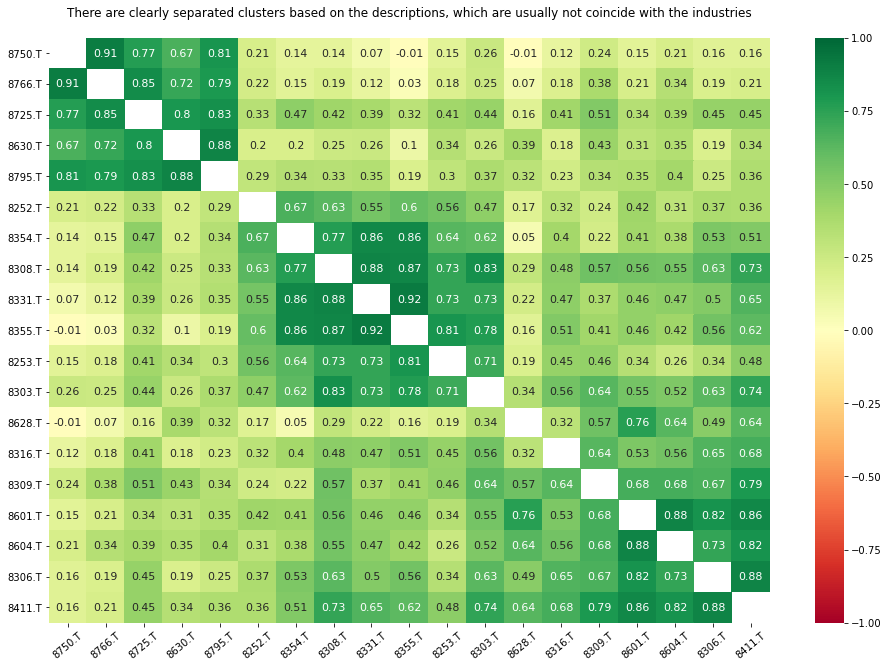

In [10]:
tics = [tics[i] for i in dend['leaves']]
plt.figure(figsize=(len(tics)*.85, len(tics)/1.5*.85));
sns.heatmap(round(cosDistMat.loc[tics, tics], 2), xticklabels=True, yticklabels=True,
            annot=True, annot_kws={"size": 11},
            mask=np.eye(len(tics)).astype(np.bool_), cmap="RdYlGn", vmin=-1, vmax=1);
plt.xticks(rotation=40);
plt.title('There are clearly separated clusters based on the descriptions, which are usually not coincide with the industries\n');

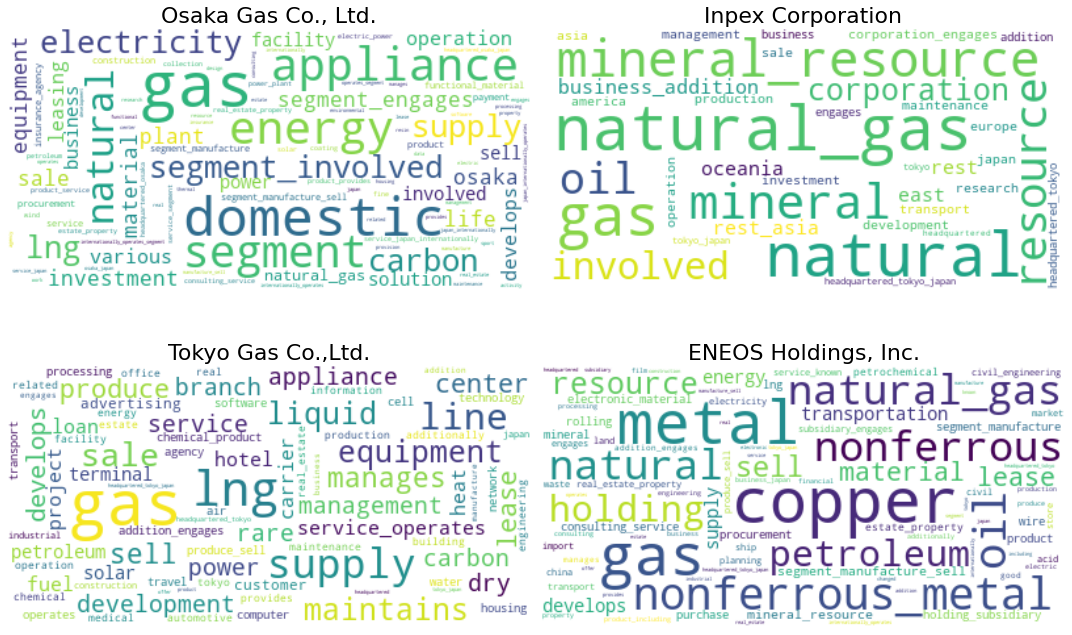

In [11]:
clus = 4
num_cols = 2

num_stocks = (clustered_tickers==clus).sum()
num_rows = num_stocks // num_cols 
if num_stocks % num_cols != 0:
    num_rows += 1
    
position = range(1,num_stocks + 1)
plt.figure(figsize=(15, num_rows * 5))
fig = plt.figure(1)

for i in range(num_stocks):
    ax = fig.add_subplot(num_rows, num_cols, position[i])
    ind = clustered_tickers.index.get_loc(list(clustered_tickers[clustered_tickers==clus].index)[i])
    freq = X_idf[ind,:].toarray()
    ngrams = list(compress(vect.get_feature_names(), (freq>0)[0]))
    ngrams = [item.replace(' ', '_') for item in ngrams]
    frequencies = zip(
        ngrams,
        freq[freq>0].tolist())
    wordcloud = WordCloud(background_color="white",max_font_size=48).generate_from_frequencies(dict(frequencies))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(comp_stats.loc[clustered_tickers[clustered_tickers==clus].index[i]].Name, fontdict={'fontsize':22})
    
    plt.axis("off");


plt.tight_layout(h_pad = 1, w_pad = 1)
plt.show()
#display(comp_stats.loc[clustered_tickers[clustered_tickers==clus].index])

In [12]:
def get_stationary_tickers(clean_prices):
    stat_tics = []
    for i in clean_prices:
        if archADF(clean_prices[fP1:fP2][i]).pvalue < 0.05:
            stat_tics.append(i)
    return stat_tics

stat_tics = get_stationary_tickers(clean_prices)
#Remove stationary price series from the dataset
clean_prices=clean_prices.drop(stat_tics, axis=1)
clustered_tickers.drop(labels = stat_tics, inplace = True)

In [13]:
brkdwn_list = []
for i in range(clustered_tickers.max()):
    brkdwn_list.append(list(clustered_tickers[clustered_tickers == i].index))

,Name,Sector,Industry,Summary
1605.T,Inpex Corporation,Energy,Oil & Gas E&P,"Inpex Corporation engages in the research, exp..."
5020.T,"ENEOS Holdings, Inc.",Energy,Oil & Gas Refining & Marketing,"ENEOS Holdings, Inc., through its subsidiaries..."
9532.T,"Osaka Gas Co., Ltd.",Utilities,Utilities—Regulated Gas,"Osaka Gas Co., Ltd. provides gas, electricity,..."
9531.T,"Tokyo Gas Co.,Ltd.",Utilities,Utilities—Regulated Gas,"Tokyo Gas Co., Ltd. produces, supplies, and se..."


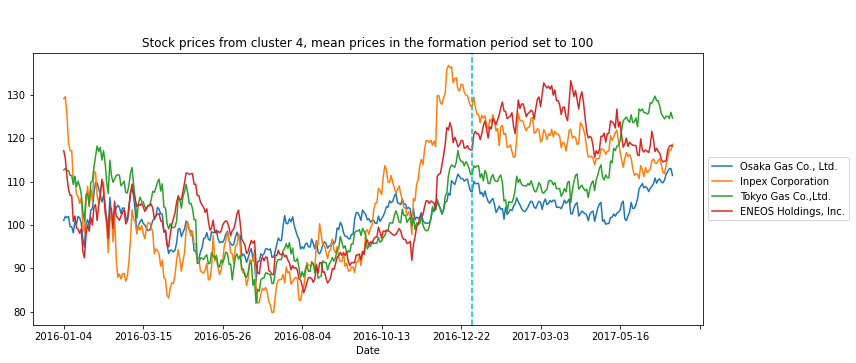

In [14]:
(100*clean_prices[brkdwn_list[clus]][fP1:tP2]/clean_prices[brkdwn_list[clus]][fP1:fP2].mean()).plot(figsize=(12,5));
plt.legend(comp_stats.loc[brkdwn_list[clus]].Name, loc='center left', bbox_to_anchor=(1, 0.5))
plt.axvline(clean_prices[fP1:fP2].shape[0], color='c', linestyle='--');
display(comp_stats.loc[brkdwn_list[clus]].sort_values(by = 'Sector'))
plt.title(f'\n\nStock prices from cluster {clus}, mean prices in the formation period set to 100');

In [15]:
def get_coint_pairs_johansen(brkdwn_list):
    total = 0
    noPosP = 0
    for i in range(len(brkdwn_list)):
        noPosP += (len(list(itertools.combinations(brkdwn_list[i],2))))

    allPosPairs = pd.DataFrame(columns=['Pair','Joh1sig','Joh2sig','autocorr','LS'],index=np.arange(noPosP))

    for i in range(len(brkdwn_list)):
        for pair in list(itertools.combinations(brkdwn_list[i],2)):
            allPosPairs.iloc[total,0] = pair

            var = VAR(clean_prices[list(pair)][fP1:fP2])
            x = var.select_order()
            model_fitted = var.fit(x.selected_orders['aic'])
            allPosPairs.iloc[total,3] = (acorr_ljungbox(model_fitted.resid.iloc[:,1],lags=x.selected_orders['aic'])[1]<0.05).sum()
            +(acorr_ljungbox(model_fitted.resid.iloc[:,0],lags=x.selected_orders['aic'])[1]<0.05).sum()
            jres = coint_johansen(clean_prices[list(pair)][fP1:fP2],det_order = 0, k_ar_diff = max(0, x.selected_orders['aic']-1))

            allPosPairs.iloc[total,1] = (jres.cvt[0]<jres.lr1[0]).sum()
            allPosPairs.iloc[total,2] = (jres.cvt[1]<jres.lr1[1]).sum()
            if jres.evec[0,0] * jres.evec[1,0] < 0:
                allPosPairs.iloc[total,4] = 1
            else:
                allPosPairs.iloc[total,4] = 0
            total += 1
            #if total % 100 == 0:
            #    clear_output(wait=True)
            #    print(total, '/', noPosP)
    return allPosPairs
allPosPairs = get_coint_pairs_johansen(brkdwn_list)
pairsJ = list(allPosPairs.query('Joh1sig>=2 & Joh2sig<2 & autocorr==0 & LS==1').Pair)
print(allPosPairs.shape[0])
print(len(pairsJ))

249
13


In [16]:
def JohSpr(pair):
    pair = list(pair)
    var = VAR(clean_prices[list(pair)][fP1:fP2])
    x = var.select_order()
    jres = coint_johansen(clean_prices[list(pair)][fP1:fP2],det_order = 0, k_ar_diff=max(0,x.selected_orders['aic']-1))
    spr = (clean_prices[pair][fP1:fP2]*jres.evec[:,0]).sum(axis=1)
    
    meanSpr = spr.mean()
    stdSpr = spr.std()
    normSpr = ((clean_prices[pair][fP1:tP2]*jres.evec[:,0]).sum(axis=1)-meanSpr)/stdSpr
    return normSpr, jres.evec[:,0], stdSpr

def pos_func(nSpr, entries, weights, stoploss=np.nan, block=False, push=True):
    posit = pd.Series(np.nan, index=nSpr[tP1:tP2].index, name='Pos')
    posit.iloc[0] = 0
    posit[nSpr*nSpr.shift(1) < 0] = 0
    for i in np.arange(len(entries)):
        posit[(nSpr+entries[i])*(nSpr.shift(1)+entries[i])< 0] = weights[i]
        posit[(nSpr-entries[i])*(nSpr.shift(1)-entries[i])< 0] = -weights[i]
    if not np.isnan(stoploss):
        posit[(nSpr+float(stoploss))*(nSpr.shift(1)+float(stoploss))< 0] = 0
        posit[(nSpr-float(stoploss))*(nSpr.shift(1)-float(stoploss))< 0] = 0
    else:
        block=False
    posit.ffill(inplace=True)
    
    if len(entries) > 1:
        for i in range(1,len(posit)):
            if abs(posit).values[i]>abs(posit).values[i-1] or abs(posit).values[i]==0 or \
            posit.values[i]*posit.values[i-1]<0:
                posit.values[i]=posit.values[i].copy()
            else:
                posit.values[i]=posit.values[i-1].copy()
    if block:
        if not nSpr[(nSpr>float(stoploss)) | (nSpr<-float(stoploss))].empty:
            posit[nSpr[(nSpr>float(stoploss)) | (nSpr<-float(stoploss))].index[0]:] = 0
    if push:
        posit=posit.shift(1)
        posit.iloc[0]=0
    return posit

def equity_curve(positions, df, weiV, initial_cash=100, leverage=2,shorting_cost=0.01,commission=0.0008,market_impact=0.002):
    trades=positions.diff()
    trades.iloc[0]=positions[0]-0
    cash=pd.Series(data=np.nan,index=positions.index,name='Cash')
    portfolio=pd.Series(data=np.nan,index=positions.index,name='Portfolio')
    shares=pd.Series(data=np.nan,index=positions.index,name='Shares')
    transaction_costs=pd.Series(data=np.nan,index=positions.index,name='Tc')
    
    portfolio.iloc[0]=initial_cash
    shares.iloc[0]=leverage*portfolio.iloc[0]/abs(df*weiV).sum(axis=1)[0]
    cash.iloc[0]=portfolio.iloc[0]-(shares[0]*df.iloc[0]*weiV*trades[0]).sum()
    transaction_costs.iloc[0]=abs(shares[0]*weiV*df.iloc[0]*trades[0]).sum()*(commission+market_impact)+(shares[0]*positions[0]*df.iloc[0]*weiV).combine(0, min).sum()*(-shorting_cost/252)

    for i in range(1,len(cash)):
        if ~(((positions[i]>0) & (trades[i]>0)) | ((positions[i]<0) & (trades[i]<0))):
            shares.iloc[i]=shares.iloc[i-1]
        else:
            shares.iloc[i]=leverage*portfolio.iloc[i-1]/abs(df*weiV).sum(axis=1)[i]
        transaction_costs.iloc[i]=abs(shares[i]*weiV*df.iloc[i]*trades[i]).sum()*(commission+market_impact)+(shares[i]*positions[i]*df.iloc[i]*weiV).combine(0, min).sum()*(-shorting_cost/252)
        cash.iloc[i]=cash.iloc[i-1]-(shares[i]*df.iloc[i]*weiV*trades[i]).sum()-transaction_costs.iloc[i]
        portfolio.iloc[i]=cash.iloc[i]+(shares[i]*positions[i]*df.iloc[i]*weiV).sum()
        
    return portfolio

In [17]:
pair_NAVs = pd.DataFrame()
slHit = 0
avgTr = []
for c, pair in enumerate(pairsJ):
    nSpr, weiV, stdSpr = JohSpr(list(pair))
    oosNSpr = nSpr[tP1:tP2]
    positions = pos_func(oosNSpr,entries=np.array([2]),weights=np.array([1.0]),block=True,stoploss=5)
    port = equity_curve(positions, clean_prices[list(pair)][tP1:tP2], weiV,shorting_cost=0.0,commission=0.0,market_impact=0.0)
    pair_NAVs = pd.concat([pair_NAVs, port], axis=1)
    #if c%10==0:
    #    clear_output(wait=True)
    #    print(c,'/',len(pairsJ))
    
    if any(abs(oosNSpr)>5):
        slHit += 1
        avgTr.append(max(0,(abs(positions.diff()).sum()/2)-1))
    else:
        avgTr.append(abs(positions.diff()).sum()/2)
    
    
strat_values = pair_NAVs.mean(axis=1)

MDD=pd.Series(np.nan,index=strat_values.index)
MDD[0]=1
for i in range(1, len(MDD)):
    MDD[i]=min(1,MDD[i-1]*(1+strat_values.pct_change()[i]))

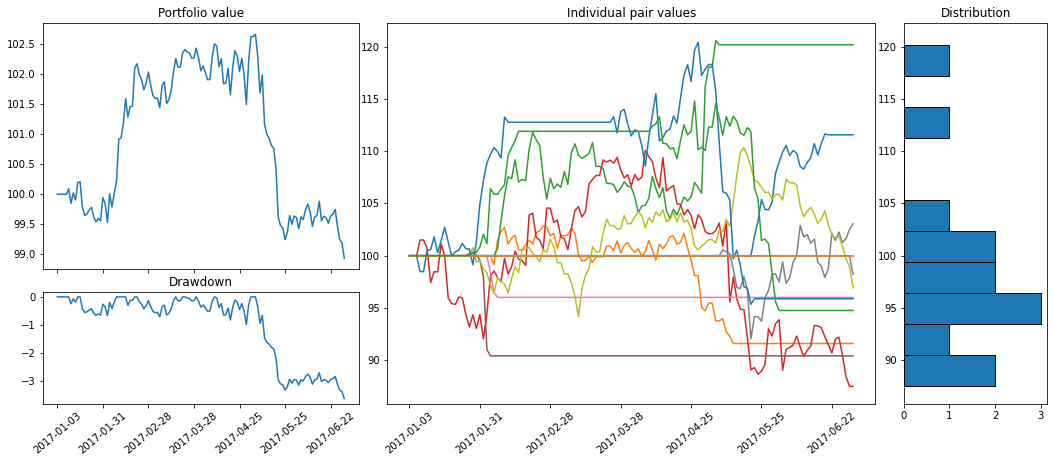

In [18]:
def plot_result():
    fig = plt.figure(figsize=(18,7));
    gs = plt.GridSpec(3,6);

    axis1 = plt.subplot(gs[0:2,0:2]);
    strat_values.plot();
    plt.title('Portfolio value');
    axis2 = plt.subplot(gs[2,0:2],sharex=axis1);
    ((MDD-1)*100).plot();
    plt.title('Drawdown');
    plt.xticks(rotation=40);
    axis3 = plt.subplot(gs[0:3,2:5]);
    for i in range(0, len(pairsJ)):
        pair_NAVs.iloc[:,i].plot(linestyle='-',legend=False);
    plt.title('Individual pair values');
    plt.xticks(rotation=40);
    axis4 = plt.subplot(gs[0:3,5],sharey=axis3);
    n = math.ceil((pair_NAVs.iloc[-1].max() - pair_NAVs.iloc[-1].min())/3);
    plt.hist(pair_NAVs.iloc[-1], bins = max(1,n), orientation='horizontal',linewidth = 1, ec='k');
    plt.title('Distribution');
    plt.show();
    
plot_result()

In [19]:
strat_returns=pd.DataFrame()
allConsDates = ['2010-01-01']
i = 1
while int(allConsDates[-1][0:4])<2021:
    allConsDates.append(str((pd.Timestamp('2010-01-01')+pd.DateOffset(months=trading_period*i)).date()))
    i += 1
allConsDates.pop()
pairsData = pd.DataFrame(0,columns=['All','Selected','StoplossHit','Profitable','AvgTrade'],index=allConsDates)

for formation_date in allConsDates:
    formation_year = int(formation_date[0:4])
    fP1, fP2, tP1, tP2 = create_dates(formation_date)
    
    clean_prices = clean_data(fP1, tP2, formation_year, stock_index)
    cleaned_final_summaries, stop_words = clean_text(comp_stats.loc[clean_prices.columns].Summary)
    vect = CountVectorizer(
        analyzer='word',
        ngram_range=(1,3),
        strip_accents='unicode',
        max_features=500,
        stop_words=stop_words)

    X = vect.fit_transform(cleaned_final_summaries)
    tfidf = TfidfTransformer()
    X_idf = tfidf.fit_transform(X)

    lsa = TruncatedSVD(n_components = 50, n_iter = 5, random_state=1)
    X_idf_lsa = lsa.fit_transform(X_idf)
    
    clustering = OPTICS(min_samples = 2, xi = 0.01, metric = 'cosine').fit(X_idf_lsa)
    clustered_tickers = pd.Series(index = clean_prices.columns,data = clustering.labels_.flatten())
    
    stat_tics = get_stationary_tickers(clean_prices)
    clean_prices=clean_prices.drop(stat_tics, axis=1)
    clustered_tickers.drop(labels = stat_tics, inplace = True)
    
    brkdwn_list = []
    for i in range(clustered_tickers.max()):
        brkdwn_list.append(list(clustered_tickers[clustered_tickers == i].index))
        
    allPosPairs = get_coint_pairs_johansen(brkdwn_list)
    pairsJ = list(allPosPairs.query('Joh1sig>=2 & Joh2sig<2 & autocorr==0 & LS==1').Pair)
    noPosP = allPosPairs.shape[0]
    
    pair_NAVs = pd.DataFrame()
    slHit = 0
    avgTr = []
    for c, pair in enumerate(pairsJ):
        nSpr, weiV, stdSpr = JohSpr(list(pair))
        oosNSpr = nSpr[tP1:tP2]
        positions = pos_func(oosNSpr,entries=np.array([2]),weights=np.array([1.0]),block=True,stoploss=5)
        port = equity_curve(positions, clean_prices[list(pair)][tP1:tP2], weiV,shorting_cost=0.0,commission=0.0,market_impact=0.0)
        pair_NAVs = pd.concat([pair_NAVs, port], axis=1)
        #if c%10==0:
        #    clear_output(wait=True)
        #    print(c,'/',len(pairsJ))

        if any(abs(oosNSpr)>5):
            slHit += 1
            avgTr.append(max(0,(abs(positions.diff()).sum()/2)-1))
        else:
            avgTr.append(abs(positions.diff()).sum()/2)
    pairsData.loc[formation_date,'StoplossHit'] = slHit
    pairsData.loc[formation_date,'All'] = noPosP
    pairsData.loc[formation_date,'Selected'] = len(pairsJ)
    pairsData.loc[formation_date,'Profitable'] = (pair_NAVs.iloc[-1]>100).sum()
    pairsData.loc[formation_date,'AvgTrade'] = sum(avgTr)/len(avgTr)

    
    strat_values = pair_NAVs.mean(axis=1)
    if strat_values.empty:
        strat_values=pd.Series(100,index=clean_prices[tP1:tP2].index)
        

    MDD=pd.Series(np.nan,index=strat_values.index)
    MDD[0]=1
    for i in range(1, len(MDD)):
        MDD[i]=min(1,MDD[i-1]*(1+strat_values.pct_change()[i]))

    strat_returns=pd.concat([strat_returns,strat_values.pct_change()],axis=0)
    
    #print('Date:',formation_date)
    #print('Final value:',strat_values[-1])
    #print('Pairs:',len(pairsJ),'/',noPosP)

    #plot_result();

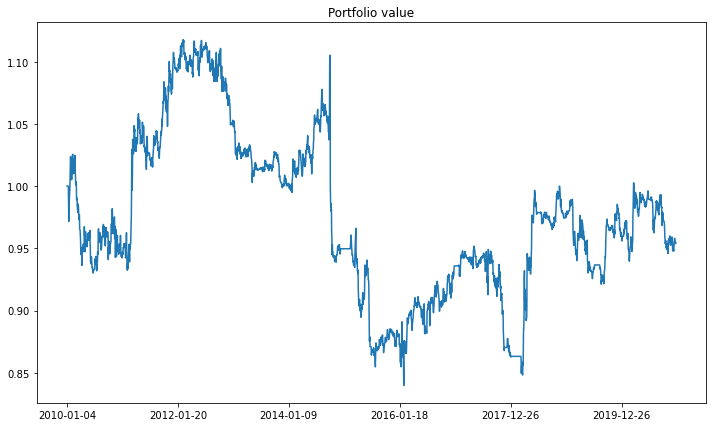

In [20]:
strat_eq=(strat_returns.fillna(0)+1).cumprod()
strat_eq.plot(figsize=(12,7),legend=False);
plt.title('Portfolio value');

In [21]:
MDD=pd.Series(np.nan,index=strat_eq.index)
MDD[0]=1
for i in range(1, len(MDD)):
    MDD[i]=min(1,MDD[i-1]*(1+strat_eq.pct_change().squeeze()[i]))
    
MDD=pd.DataFrame(data=MDD,columns=['MDD'])
MDD['Periods']=(np.where((MDD!=1) & (MDD.shift(1)==1),1,0)).cumsum()
MDD['Periods']=(np.where((MDD['MDD']==1) & (MDD['MDD'].shift(1)==1),0,MDD['Periods']))
temp_rows=[]
for i in range(1,MDD['Periods'].max()+1):
    #print(f"{(MDD[MDD['Periods']==i]['MDD'].min()-1)*100:.2f}%")
    drawdown=(MDD[MDD['Periods']==i]['MDD'].min()-1)
    length=len(MDD[MDD['Periods']==i])
    start=MDD[MDD['Periods']==i].iloc[0].name
    end=MDD[MDD['Periods']==i].iloc[-1].name
    temp_rows.append([drawdown, length, start, end])
temp_rows
MDD_stats=pd.DataFrame(data=temp_rows,columns=['Drawdown','Length','Start','End'])

monthly_strat2=[strat_eq.iloc[0].item()]
for year in range(2010,2021):
    for month in range(1,13):
        monthly_strat2.append(strat_eq[:str(date(year,month,calendar.monthrange(year, month)[1]))].iloc[-1].item())

,Drawdown,Length,Start,End
14,-0.248739,2220,2012-02-24,2020-12-30
2,-0.093130,266,2010-02-12,2011-03-15
7,-0.042273,110,2011-04-28,2011-10-07
9,-0.032943,23,2011-10-18,2011-11-18
3,-0.032100,4,2011-03-16,2011-03-22


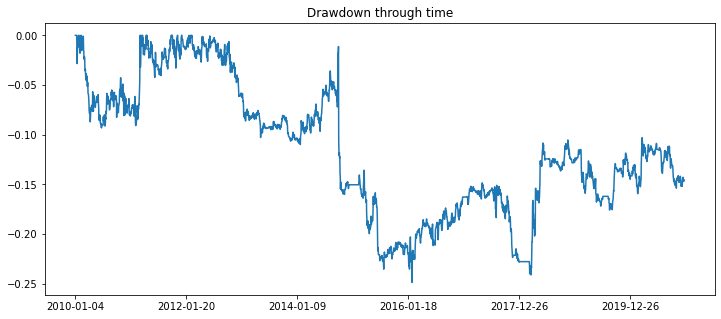

In [22]:
(MDD['MDD']-1).plot(figsize=(12,5));
plt.title('Drawdown through time')
MDD_stats.sort_values(by='Drawdown',ascending=True).head(5)

In [23]:
print('Annual excess return:',strat_eq.iloc[-1].item()**(1/11)-1-0.0055)
print('Annual volatility:',(np.std(strat_returns.fillna(0))*(len(strat_returns.fillna(0))/11)**.5).item())
print('Sharpe ratio:',((strat_eq.iloc[-1].item()**(1/11)-1)-0.0055)/((np.std(strat_returns.fillna(0))*(len(strat_returns.fillna(0))/11)**.5).item()))
print('Positive months:',(pd.Series(monthly_strat2).pct_change()>0).sum(),'/ 132\t',(pd.Series(monthly_strat2).pct_change()>0).sum()/132)

Annual excess return: -0.00973490411842986
Annual volatility: 0.08169516351040434
Sharpe ratio: -0.11916132730660445
Positive months: 71 / 132	 0.5378787878787878


In [24]:
pairsData.mean()

All            207.909091
Selected        10.409091
StoplossHit      5.136364
Profitable       3.772727
AvgTrade         0.680984
dtype: float64